# BlazeFace Inference Tutorial

This is a brief tutorial that shows how to use a trained BlazeFace for inference on the Pascal VOC datasets.

In [1]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread	
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxesBlazeFace import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.
/workspace/blazeface_keras/data_generator/object_detection_2d_data_generator.py:44: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [2]:
# Set the image size.
img_height = 128
img_width = 128

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[[0.2, math.sqrt(0.2 * 0.43)], [0.43, math.sqrt(0.43 * 0.67), 0.67, math.sqrt(0.67 * 0.9), 0.9, math.sqrt(0.9 * 1)]], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
                steps=[64, 128],
                offsets=None,
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[121, 111, 105],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.1,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/blazeface_with_landmark_simple_v3_epoch-49_loss-17.6621.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

------------------y_pred-------------------
Tensor("predictions/concat:0", shape=(None, None, 24), dtype=float32)
----------------coords------------------------
Tensor("decoded_predictions/sub:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/sub_1:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/add_2:0", shape=(None, None), dtype=float32) Tensor("decoded_predictions/add_3:0", shape=(None, None), dtype=float32)
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Or

### 1.2. Load a trained model

In [35]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'blazeface_1class_fddb_07+12_epoch-33_loss-4.3087_val_loss-2.9612.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'DecodeDetections': DecodeDetections,
#                                                'compute_loss': ssd_loss.compute_loss})

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [8]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
# img_path = 'data/widerface/val/images/19--Couple/19_Couple_Couple_19_810.jpg'
img_path = './1_20200824_night_light_02_2 12.jpg'
orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions

In [9]:
y_pred = model.predict(input_images)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [10]:
confidence_threshold = 0.5
print(y_pred.shape)
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('class conf xmin ymin xmax ymax kp1_x kp1_y kp2_x kp2_y kp3_x kp3_y kp4_x kp4_y kp5_x kp5_y')
print(y_pred_thresh[0])
print(y_pred_thresh[0].shape)

(1, 200, 16)
Predicted boxes:

class conf xmin ymin xmax ymax kp1_x kp1_y kp2_x kp2_y kp3_x kp3_y kp4_x kp4_y kp5_x kp5_y
[[ 1.    0.6  43.91 40.27 78.27 90.1  48.73 59.2  68.88 58.48 58.07 73.4  50.41 84.72
  66.22 83.85]]
(1, 16)


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

853


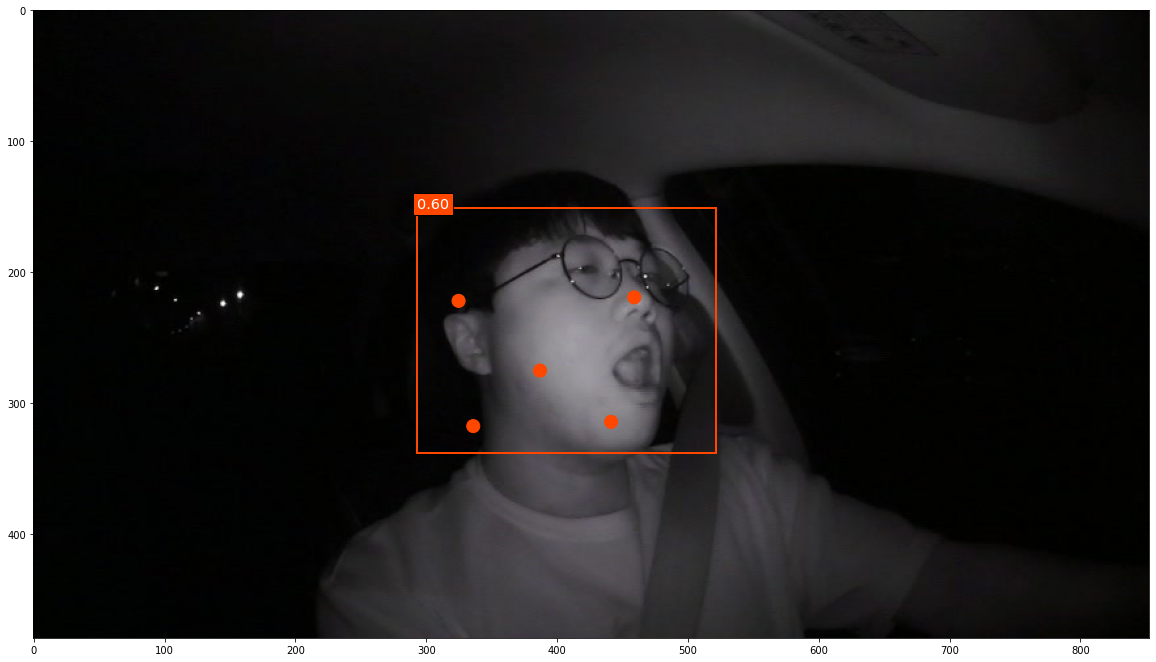

In [11]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'face']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()
print(orig_images[0].shape[1])
for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width 
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    kp1_x = box[6] * orig_images[0].shape[1] / img_width 
    kp1_y = box[7] * orig_images[0].shape[0] / img_height
    kp2_x = box[8] * orig_images[0].shape[1] / img_width
    kp2_y = box[9] * orig_images[0].shape[0] / img_height
    kp3_x = box[10] * orig_images[0].shape[1] / img_width
    kp3_y = box[11] * orig_images[0].shape[0]  / img_height
    kp4_x = box[12] * orig_images[0].shape[1] / img_width
    kp4_y = box[13] * orig_images[0].shape[0]  / img_height
    kp5_x = box[14] * orig_images[0].shape[1] / img_width
    kp5_y = box[15] * orig_images[0].shape[0]  / img_height
    
    
    
    color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.add_patch(plt.Circle((kp1_x,kp1_y),5,color=color))
    current_axis.add_patch(plt.Circle((kp2_x,kp2_y),5,color=color))
    current_axis.add_patch(plt.Circle((kp3_x,kp3_y),5,color=color))
    current_axis.add_patch(plt.Circle((kp4_x,kp4_y),5,color=color))
    current_axis.add_patch(plt.Circle((kp5_x,kp5_y),5,color=color))
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.text(xmin, ymin, f'{box[1]:.2f}', size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [ ]:
import tensorflow as tf
import math
import os
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder_blazeface import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

img_height = 128 # Height of the model input images
img_width = 128 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [[0.2, math.sqrt(0.2 * 0.43)], [0.43, math.sqrt(0.43 * 0.67), 0.67, math.sqrt(0.67 * 0.9), 0.9, math.sqrt(0.9 * 1)]]
aspect_ratios = [[1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]] # The anchor box aspect ratios
steps = [64, 128] # The space between two adjacent anchor box center points for each predictor layer.
offsets = None # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True


ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

In [9]:
test_anno_file = "./data/FDDB/FDDB-test.csv"
images_dir = "./data/FDDB/originalPics/"


test_dataset = DataGenerator(load_images_into_memory=False)
test_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=test_anno_file,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

batch_size = 1

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)


generator = test_dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

In [10]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./data/FDDB/originalPics/2002/08/17/big/img_238.jpg

Ground truth boxes:

[[  1 139 170 213 282]
 [  1 179  15 234  87]
 [  1 254   0 302  38]]


In [11]:
# Predict.

y_pred = model.predict(batch_images)

In [12]:
confidence_threshold = 0.2

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.84 140.   145.   218.   288.  ]
 [  1.     0.63 166.    10.   246.   135.  ]]


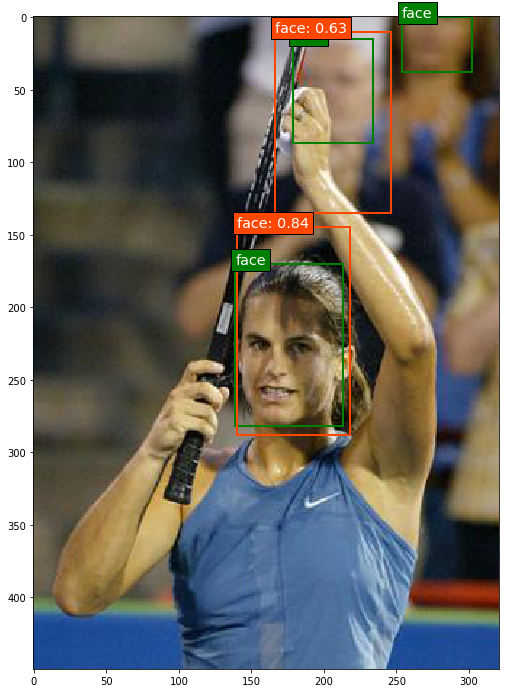

In [13]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
61--Street_Battle/61_Street_Battle_streetfight_61_833.jpg